# Algoritmo de Shor implementado en Qiskit
Para el caso N=15, A = 7
### Autores
Álvaro Cabo & Oussema El-Hatifi

## Instalación de dependencias
Para poder ejecutar este proyecto, simplementes necesitamos la librería core de qiskit, con ella podremos tanto conectarnos al backend como utilizar sus algortimos built-in
- [Guía de easy set-up para qiskit](https://docs.quantum.ibm.com/start/install)

In [1]:
# Recomendamos crear un entrono virtual para instalar las dependencias
# python -m venv .venv
# source .venv/bin/activate (Linux)

%pip install qiskit-ibm-runtime qiskit-ibmq-provider python-dotenv matplotlib pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Selección de backend
Para poder ejecutar nuestro código en un ordenador cuántico, hacemos uso del *Cloud Quantum Computing*
> IBM provides tools for a beginner to learn and use the quantum computer using the visual programming tool that converts the codes into interactable nodes and still provide the user the code that they make using the visual programming[14]. While Qutech’s quantum computer only provides the user the tool to write the code for the quantum computer 

Además contamos con una prueba gratuita de 10 minutos

In [2]:
import os
from dotenv import load_dotenv

load_dotenv('.env')

from qiskit import *
from math import pi, gcd

try:
    IBMQ.enable_account(os.environ.get("API_KEY"))
except:
    print("The acount has already been enabled")

provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')


/tmp/ipykernel_10735/849483757.py:10: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.enable_account(os.environ.get("API_KEY"))
/tmp/ipykernel_10735/849483757.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.enable_account(os.environ.get("API_KEY"))


## Implementación de la Transformada Cuántica de Fourier
Implementa físicamente en los cubits su valor en base computacional, no hace ningún cómputo, solo “traslada” la información a un dominio donde puede operar más fácil

[Video divulgación QFT](https://www.youtube.com/watch?v=MiFPhbLw9Aw)

In [3]:
def QFT(n):
    qft_circ = QuantumCircuit(n) # Colección de n qubits
    for i in range(n-1, -1, -1): # from n-1 to 0
        qft_circ.h(i) # Qubit en estado de superposición
        for j in range(i - 1, -1, -1): 
            # Hacemos el CU1 con todos los qubits que quedan por encima
            theta = pi/(2 ** (i - j)) # Angulo de rotación
            qft_circ.cu(theta, 0, 0, 0, j, i)
    for i in range(n // 2): # Damos la vuelta a los valores
        qft_circ.swap(i, n - i - 1)
    # Convertimos el circuito en una puerta para poder integrarlo en nuestro circuito de Shor
    gate = qft_circ.to_gate(label="QFT" + str(n))
    return gate

## Puerta U(f)
Implementamos la puerta que realiza la operación `|x0> -> |xf(x)>`

Para nuestro caso, esta puerta realiza la operación `7 mod(15)` en el circuito

In [4]:
def _7mod15():
    circ = QuantumCircuit(8) # Colección de 8 qubits
    circ.x(4) # Flipeamos el qubit 4
    # CNOTs -> Flipeamos si el qubit de control (1º) es |1>
    circ.cx(0,5)
    circ.cx(0,6)
    circ.cx(1,4)
    circ.cx(1,6)
    for i in range(4,8):
        # CCNOTs -> Flipeamos si los dos qubits de control son |1>
        circ.ccx(0,1,i)
    gate = circ.to_gate(label="7mod15")
    return gate

## Creando el circuito -> Encontrar el periodo
Implementamos la parte cuántica del algoritmo según se describe:
1. Ponemos los 4 primeros qubits en estado de superposición
2. Ejecutamos la función `f -> Uf` (Multiplicación modular) para encontrar los posibles pares de resultados
3. Medimos los 4 últimos qubits sin que nos importe el resultado
4. Eliminamos el residuo |x0> utilizando la QFT
5. El valor al que colapse la medición de los 4 qubits restantes será una aproximación racional de `15/t`, por lo que podríamos despejar t

/home/varo/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


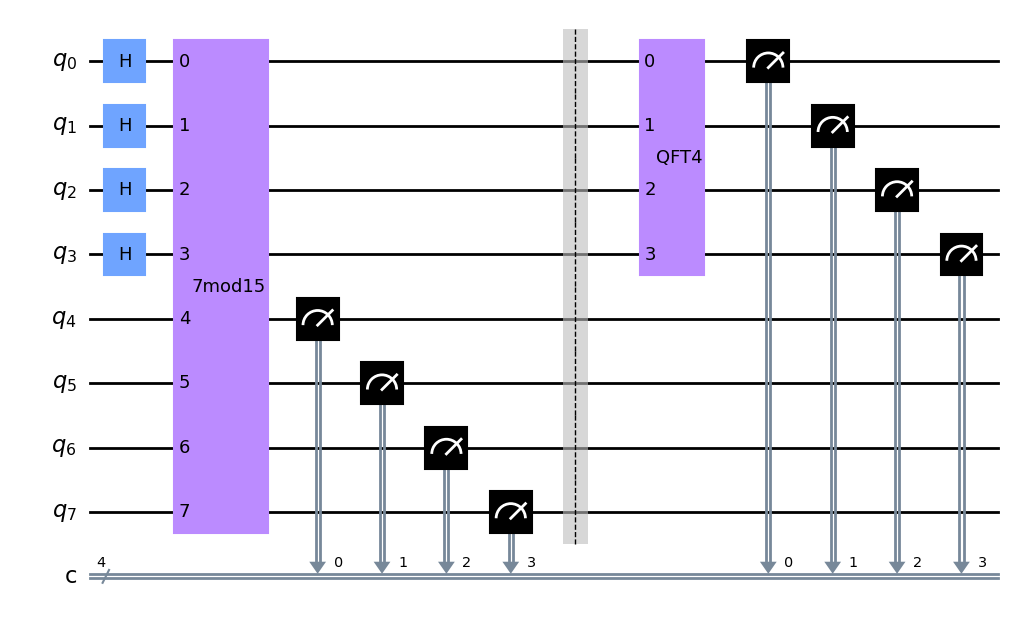

In [5]:
circ = QuantumCircuit(8,4)
circ.h(range(4)) # Ponemos los 4 primeros qubits en estado de superposición
circ.append(_7mod15(), range(8)) # Añadimos el circuito de 7mod15
circ.measure(range(4,8),range(4)) # Medimos los 4 últimos qubits sin que nos importe el resultado
circ.barrier(range(8)) # Añadimos una barrera para separar los dos circuitos
circ.append(QFT(4), range(4)) # Añadimos el circuito de QFT
circ.measure(range(4), range(4)) # Medimos los 4 primeros qubits
circ.draw(output = 'mpl')

## Ejecutando el código en el back
Con este resultado, obtendremos el periodo de la función

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


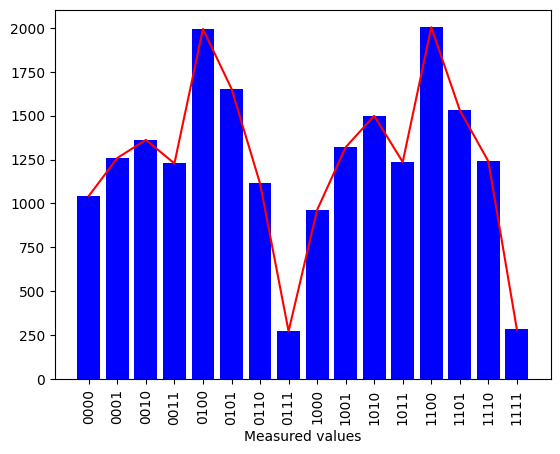

In [6]:
job = execute(circ, backend, shots=20000)
result = job.result()
counts = result.get_counts()

import matplotlib.pyplot as plt
sorted_counts = {k: counts[k] for k in sorted(counts.keys())}  # Sort the keys
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='b')
plt.plot(sorted_counts.keys(), sorted_counts.values(), 'r-')

# Increase the space between bar key labels
plt.xticks(rotation=90)

plt.xlabel('Measured values')
plt.show()

## Analizando los resultados
Utilimos los convergentes de la fracción continua para obtener aproximaciones racionales p/q del periodo r.

>Para encontrar valor en estos resultados, tenemos que tener en cuenta que la onda que recibimos no tiene forma sinusoidal, por lo que contiene armónicos (Valores residuales).

Aceptamos 4 y 12 como posibles soluciones, porque `7^4 mod(15)=1` y como 12 == 0 mod4, entonces podemos concluir que, siendo p*q=15:

In [7]:
periodo = [4,12]
resultado = -1
for i in periodo:
    p = gcd(i-1, 15)
    q =  gcd(i+1, 15)
    if p*q == 15:
        resultado = i
        break
print(f"El periodo de la funcion es {resultado}")
print(f"Factores primos: p = {p}, q = {q}")

El periodo de la funcion es 4
Factores primos: p = 3, q = 5
